## RNN and LSTM Model Calibration 
Done by: Chamath Wijerathne, Nada Rahali, Tanjuma Haque

In [1]:
# pip install kagglehub

In [2]:
# pip install statsmodels

In [3]:
# import libraries
import kagglehub
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam

## Initial exploratory analysis

In [4]:
# load the dataset
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\anura\.cache\kagglehub\datasets\uciml\electric-power-consumption-data-set\versions\1


In [5]:
os.listdir(path)

['household_power_consumption.txt']

In [6]:
file_path = os.path.join(path, "household_power_consumption.txt")
df = pd.read_csv(file_path, sep=";", na_values="?", low_memory=False)
df.head()

Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0

In [7]:
# combine date and time columns
# convert to datetime and set as index
df["DateTime"] = pd.to_datetime(df["Date"] + " " + 
                                df["Time"],format="%d/%m/%Y %H:%M:%S")
df = df.set_index("DateTime")
df = df.drop(columns=["Date", "Time"])

KeyboardInterrupt: 

In [ ]:
df.head()

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
DateTime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [ ]:
# check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


Some timestamps contain no measurement values at all, the dataset contains 25,979 rows with missing measurement values, corresponding to approximately 1.25% of all timestamps which matches with the dataset description. 

In [ ]:
# check for missing timestamps 'jumps' in the datetime index
df.index.to_series().diff().value_counts().head(10)

DateTime
0 days 00:01:00    2075258
Name: count, dtype: int64

Based on the results of the code above, the datetime index shows a consistent 1-minute interval with no missing timestamps meaning we don't need to enforce frequency. Therefore, only the measurement values are missing, not the timestamps which will be addressed through linear interpolation. 

In [ ]:
# handle missing values using linear interpolation
df = df.interpolate()
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Now that the dataset is cleaned and the missing values have been handled, we can begin exploring the time-series characteristics.
To understand the dataset better, we will:
1. Check the time range of the dataset (start and end date).

2. Compute the target variable y: y = (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3)
   
   y = the energy used by all the appliances that are not in the 3 sub-meters => unmeasured energy
   
3. Visualize the target variable y over time.
  
1. Identify visible patterns such as daily, weekly, or yearly patterns, trends, or changes in target variable y. 

In [ ]:
# check the time range of the dataset (start and end date).
df.index.min(), df.index.max()

(Timestamp('2006-12-16 17:24:00'), Timestamp('2010-11-26 21:02:00'))

In [ ]:
# compute the target variable y 
# y = (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3)
df["y"] = (df["Global_active_power"] * 1000 / 60) - df["Sub_metering_1"] - df["Sub_metering_2"] - df["Sub_metering_3"]

In [ ]:
df[["y"]].head()

y
DateTime                      
2006-12-16 17:24:00  52.266667
2006-12-16 17:25:00  72.333333
2006-12-16 17:26:00  70.566667
2006-12-16 17:27:00  71.800000
2006-12-16 17:28:00  43.100000

In [ ]:
df.head()

Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3          y  
DateTime                                        
2006-12-16 17:24:00            17.0  52.266667  
2006-12-16 17:25:00            16.0  72.333333  
2006-12-16 17:26:00            17.0  70.566667  
2006-12-16 17:27:00            17.0  71.800000  
2006-12-16 17:28:00            17.0  43.100000

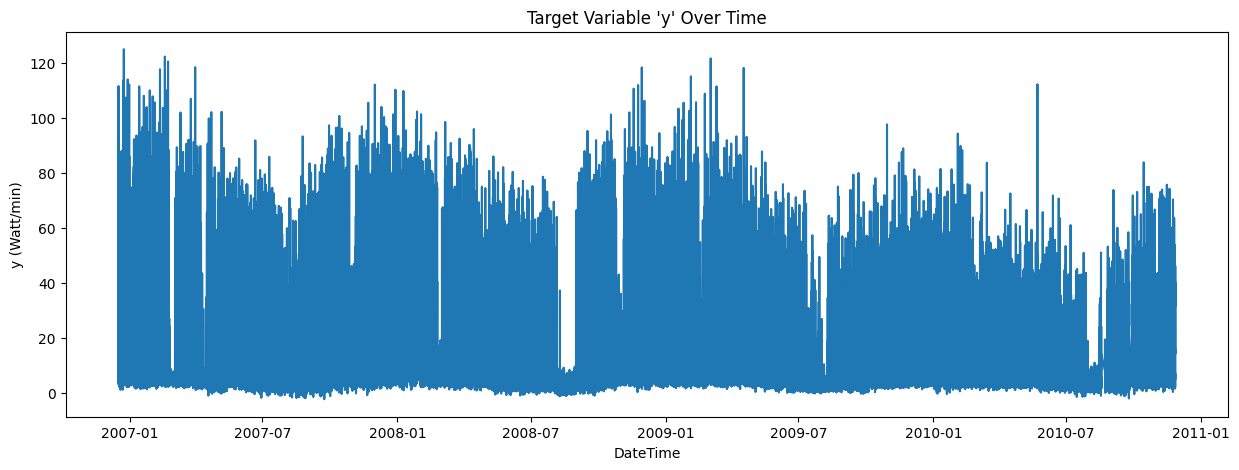

In [ ]:
# visualize the target variable 'y' over time 'per minute'
plt.figure(figsize=(15,5))
plt.plot(df.index, df["y"], label="y", color="#1f77b4")
plt.xlabel("DateTime")
plt.ylabel("y (Watt/min)")
plt.title("Target Variable 'y' Over Time")
plt.show()


The minute-level plot is highly noisy, which was a bit hard to understand and explain, that is why the hourly and daily plots are visualized to better understand the seasonality shape. 

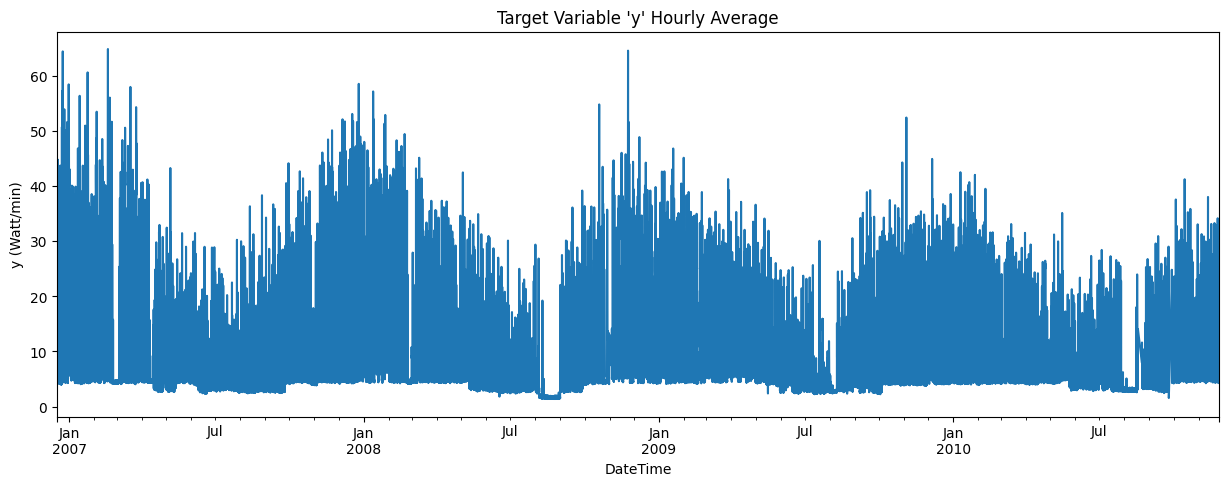

In [ ]:
# visualize the target variable 'y' hourly
plt.figure(figsize=(15,5))
df["y"].resample("h").mean().plot()
plt.title("Target Variable 'y' Hourly Average")
plt.xlabel("DateTime")
plt.ylabel("y (Watt/min)")
plt.show()


The hourly averaged data shows the same general seasonal structure: 
- higher peaks during certain hours (morning/evening)
- lower consumption overnight
- seasonal differences more clearly

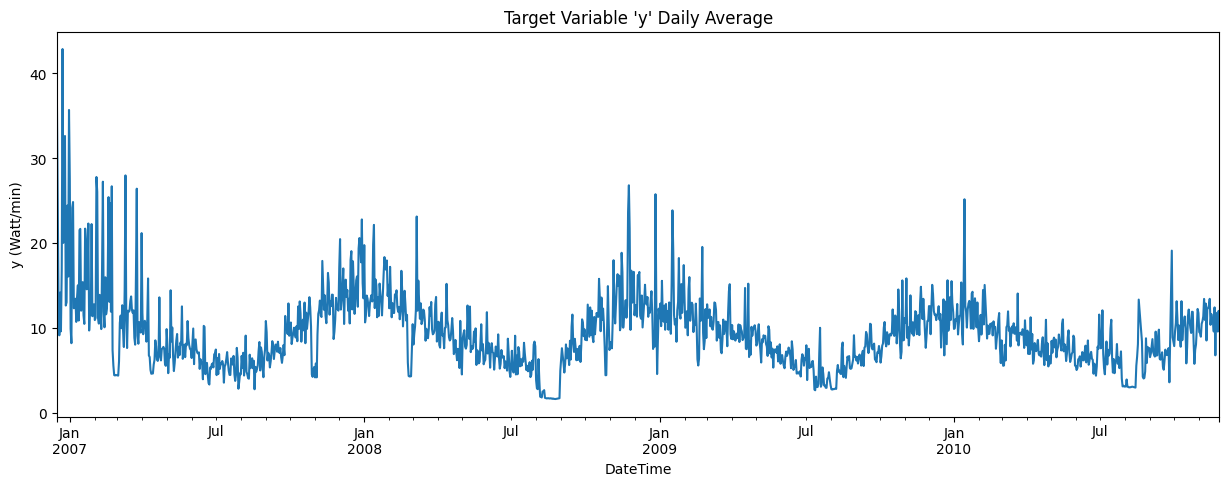

In [ ]:
# visualize the target variable 'y' daily
plt.figure(figsize=(15,5))
y_daily = df["y"].resample("D").mean()
y_daily.plot()
plt.title("Target Variable 'y' Daily Average")
plt.xlabel("DateTime")
plt.ylabel("y (Watt/min)")
plt.show()

Energy usage is highest during the winter months (December–February), where the daily average reaches approximately 20–30 Wh/min. This is likely happening due to eletric heating, lights for longer hours, water heaters.. 

From January to July, the daily averages gradually decrease, reaching a minimum of around 5–10 Wh/min in midsummer. During summer months, heating demand is less compared to winter, daylight hours are longer, and residents tend to use fewer appliances.

From July onward, consumption increases again as winter approaches, repeating the seasonal cycle each year.

## Time-series decomposition analysis of long-term trend, seasonality, and residuals

In [ ]:
df.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.090280e+00           1.236492e-01  2.408328e+02   
std           1.052628e+00           1.124194e-01  3.237763e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.100000e-01           4.800000e-02  2.389900e+02   
50%           6.140000e-01           1.000000e-01  2.410000e+02   
75%           1.528000e+00           1.940000e-01  2.428700e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
count      2.075259e+06    2.075259e+06    2.075259e+06    2.075259e+06   
mean       4.621481e+00    1.109485e+00    1.289229e+00    6.442386e+00   
std        4.424361e+00    6.115843e+00    5.786613e+00    8.415860e+00   
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00   
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00   
50%        2.751585e+00    0.000000e+00    0.000000e+00    1.000000e+00   
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01   
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01   

                  y  
count  2.075259e+06  
mean   9.330226e+00  
std    9.546528e+00  
min   -2.400000e+00  
25%    3.833333e+00  
50%    5.533333e+00  
75%    1.046667e+01  
max    1.248333e+02

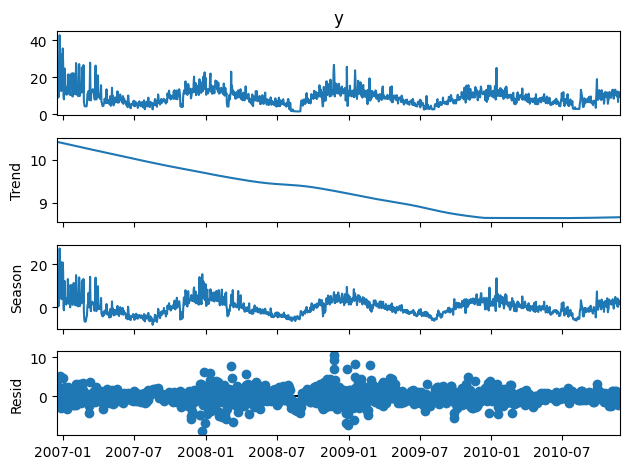

In [ ]:
# STL decomposition on daily data
stl = STL(y_daily, period=365)
res = stl.fit()
fig = res.plot()


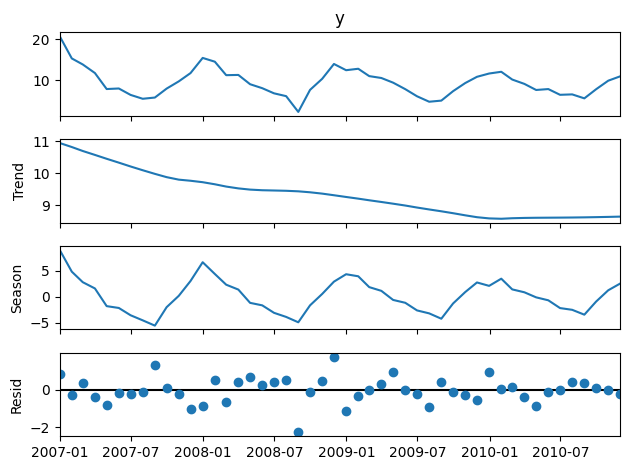

In [ ]:
# STL decomposition on monthly data
y_monthly = df["y"].resample("ME").mean()

stl = STL(y_monthly, period=12, seasonal=13, trend=21)
res = stl.fit()
res.plot()
plt.show()


Based on my understandings of the plots, the stl decomposition shows 3 main components: 

- Observed: the daily plot is very spiky, because energy usage differ a lot day-to-day. However, in the monthly data, it is much cleaner which is best for interpretation. 

- Trend => long-term upward: The long-term trend is lightly decreasing from ~11 to ~9 same goes for the monthly data. 

- Seasonality => repeating yearly patterns: Higher energy consumption during winter months (December–February), which means more energy. While, Lower energy usage during summer months (June–August) => less energy. 

- Residual => random noise: The residuals of the daily STL decomposition are mostly small and randomly distributed around zero, which does not show clear patterns of daily ouliers, in this case applying the robust fitting will be better to make the decomposition more robust to outliers. Compared to monthly stl, residuals looks clean no need for robust fitting. 

However, monthly decomposition shows smoother and more interpretable components, while daily decomposition is noisier and benefits from robust fitting.

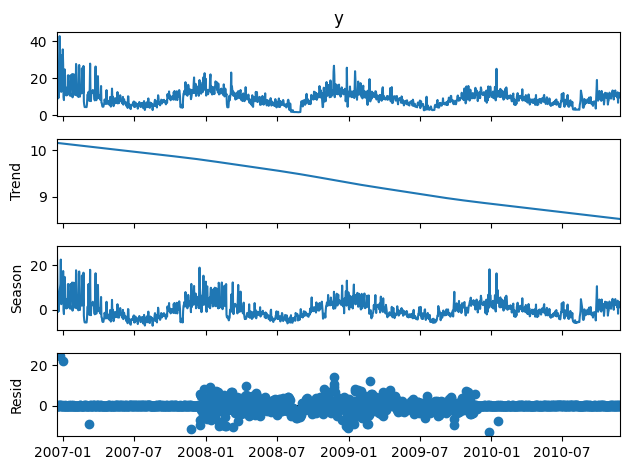

In [ ]:
# robust fitting stl on daily data
stl_robust = STL(y_daily, period=365, robust=True)
res_robust = stl_robust.fit()
res_robust.plot()
plt.show()

Robust fitting (robust=True) was used to prevent these outliers from distorting the trend and seasonality.The residual component appears noisy with visible outliers, because if we look at the y-series, daily consumption is irregular, some days have very high power use. When STL removes the trend and seasonality, those unpredictable jumps end up in the residual plot.

## An autocorrelation analysis of the dataset

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

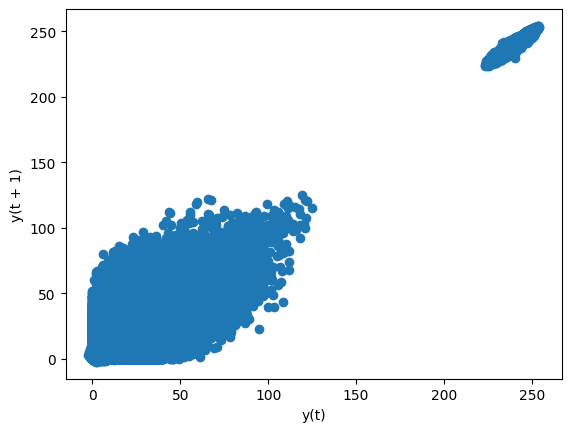

In [ ]:
# autocorrelation analysis lag(1) - today vs yesterday
df.head(15)
pd.plotting.lag_plot(df, lag=1)

The scatter plot shows y(t) on the x-axis and y(t+1) (the next observation) on the y-axis. There are 2 seperate groups of points: cluster 1, values between 0 and 120 representing majority of the data, which I suppose the standard behaviour (daily patterns). While cluster 2 cointains fewer points around 220 and 260 and they are very close together. 

In [ ]:
# create lagged dataframe for autocorrelation matrix
y = df["y"].copy()

# Create lagged versions
df_lags = pd.DataFrame({
    "y(t-3)": y.shift(3),
    "y(t-2)": y.shift(2),
    "y(t-1)": y.shift(1),
    "y(t)":   y,
})

# remove rows with NaN due to shifting
df_lags = df_lags.dropna()

# compute correlation matrix
corr_matrix = df_lags.corr()
corr_matrix

y(t-3)    y(t-2)    y(t-1)      y(t)
y(t-3)  1.000000  0.952737  0.907180  0.877162
y(t-2)  0.952737  1.000000  0.952738  0.907179
y(t-1)  0.907180  0.952738  1.000000  0.952737
y(t)    0.877162  0.907179  0.952737  1.000000

<Figure size 1400x600 with 0 Axes>

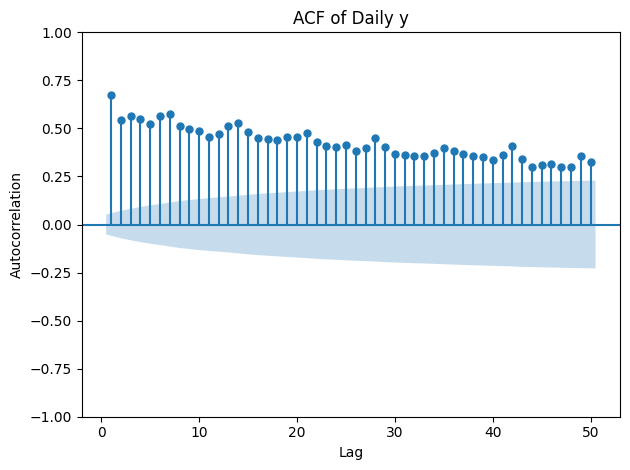

In [ ]:
plt.figure(figsize=(14,6)) 
plot_acf(
    y_daily, 
    lags=50,
    zero=False,          
)
plt.title("ACF of Daily y")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


The autocorrelation starts at 0.70 which means that today’s consumption is highly dependent on yesterday’s value 'lag(1)'. The autocorrelation decreases gradually but remains well above zero for more than 50 lags, meaning that past values influence the future values . 

## Data pretreatment

In [ ]:
df.index.name

'DateTime'

In [ ]:
# continuous measurement frequency check
# the datetime column has been set as index

# calculate time differences between consecutive timestamps
time_diffs = df.index.to_series().diff().dropna()
freq_counts = time_diffs.value_counts().sort_index()

print("Sampling frequency counts:")
print(freq_counts)

Sampling frequency counts:
DateTime
0 days 00:01:00    2075258
Name: count, dtype: int64


As examined in the week ML2 submission, the most common time difference between consecutive measurements is 1 minute, and all the samples follow this exact 1-min-interval, which has been checked whether the continuous measurements have the same frequency, meaning I computed the time difference between consecutive timestamps. The results show that every measurement is exactly one minute apart (0 days 00:01:00), with a total count of 2,075,258 observations. Therefore, the dataset has a uniform sampling frequency, and no additional preprocessing or sampling is required. 

In [ ]:
# data synchronicity across all variables
# check how many rows have at least one missing value
missing_rows = df.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {missing_rows}")

# check if any variable has a different count of missing values
missing_counts = df.isnull().sum()
print("Missing values per variable:")
print(missing_counts)

# check if any duplicate timestamps exist
duplicate_timestamps = df.index.duplicated().sum()
print(f"Number of duplicate timestamps: {duplicate_timestamps}")


Number of rows with at least one missing value: 0
Missing values per variable:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
y                        0
dtype: int64
Number of duplicate timestamps: 0


I looked at the missing value pattern and confirmed that each variable had the same timestamp index to see if the data was synchronous across all variables. According to the results, no variable has any missing values, and no row has any partially missing data. Furthermore, no timestamps are repeated. This confirms that all variables are perfectly aligned and measured at the same 1-minute intervals. No additional steps like resampling, interpolation, forward filling, or timestamp alignment are necessary because the dataset is completely synchronous.

In [ ]:
# check if missing values exist
# check total missing values
total_missing = df.isnull().sum().sum()
print("Total missing values:", total_missing)

# check missing values per variable
missing_per_column = df.isnull().sum()
print("\nMissing values per variable:")
print(missing_per_column)

Total missing values: 0

Missing values per variable:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
y                        0
dtype: int64


In [ ]:
# check for consecutive missing values
consecutive_missing = {}

for col in df.columns:
    is_na = df[col].isna().astype(int)

    # Detect consecutive NA streaks
    changes = np.diff(np.where(np.concatenate(([is_na.iloc[0]],
                                               is_na.values[:-1] != is_na.values[1:],
                                               [True])))[0])[::2]

    consecutive_missing[col] = changes.max() if len(changes) > 0 else 0

print("\nConsecutive missing values per variable:")
print(consecutive_missing)


Consecutive missing values per variable:
{'Global_active_power': 0, 'Global_reactive_power': 0, 'Voltage': 0, 'Global_intensity': 0, 'Sub_metering_1': 0, 'Sub_metering_2': 0, 'Sub_metering_3': 0, 'y': 0}


The dataset was already checked for missing values in Week ML2, but none were found.   By checking the overall number of missing entries and the number of missing values in each variable, I confirmed this once more in Week ML3. There were no missing values in any of the columns.
I identified the longest streak of missing values for every variable, and all maximum streak lengths were zero, to make sure there were no consecutive missing-value segments. This demonstrates that all timestamps in the dataset have complete observations.
While imputation is not necessary for this dataset, forward fill, backward fill, linear interpolation are common methods for filling in missing values in time-series data.

In [ ]:
# STL decomposition to spot and eliminate possible outliers
# daily seasonality 
series = y_daily

# weekly seasonal period (7 days)
stl = STL(series, period=7)
result = stl.fit()

residuals = result.resid

# outlier detection based on residuals
threshold = 3 * residuals.std()
outlier_mask = np.abs(residuals) > threshold
outlier_indices = series.index[outlier_mask]

print("Number of outliers detected:", outlier_mask.sum())
print("Example outlier timestamps:", outlier_indices[:5])


Number of outliers detected: 28
Example outlier timestamps: DatetimeIndex(['2006-12-19', '2006-12-23', '2006-12-24', '2006-12-26',
               '2006-12-30'],
              dtype='datetime64[ns]', name='DateTime', freq=None)


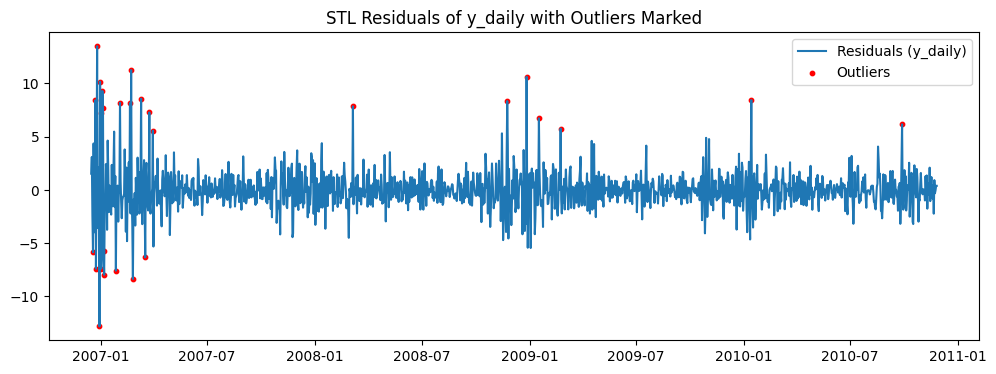

In [ ]:
# plot residuals with outliers marked
plt.figure(figsize=(12,4))
plt.plot(residuals, label="Residuals (y_daily)")
plt.scatter(outlier_indices, residuals[outlier_mask], 
            color='red', s=10, label="Outliers")
plt.title("STL Residuals of y_daily with Outliers Marked")
plt.legend()
plt.show()

# cleaning
y_daily_cleaned = series.copy()
y_daily_cleaned[outlier_mask] = np.nan
y_daily_cleaned = y_daily_cleaned.interpolate()

df_y = y_daily_cleaned

In [ ]:
# eliminate outliers 
df_y = y_daily.copy()
df_y[outlier_mask] = np.nan
df_y = df_y.interpolate()
df_y

DateTime
2006-12-16    37.073064
2006-12-17    25.657407
2006-12-18    13.214190
2006-12-19    13.685150
2006-12-20    14.156111
                ...    
2010-11-22    11.753194
2010-11-23    11.355741
2010-11-24     9.562130
2010-11-25    11.999120
2010-11-26    10.568277
Freq: D, Name: y, Length: 1442, dtype: float64

## Baseline Model 

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 465.9162 - val_loss: 274.0728
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 366.8599 - val_loss: 213.8093
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 285.4327 - val_loss: 164.0616
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 219.1689 - val_loss: 124.5036
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 166.8639 - val_loss: 93.0370
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 125.6883 - val_loss: 69.0290
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.2674 - val_loss: 50.8289
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70.5639 - val_loss: 37.3639
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.2045 - val_loss: 27.5086
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.7173 - val_loss: 20.5460
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.9307 - val_loss: 15.7686
Epoch 12/100
36/36 ━━━━━━━━━━━━

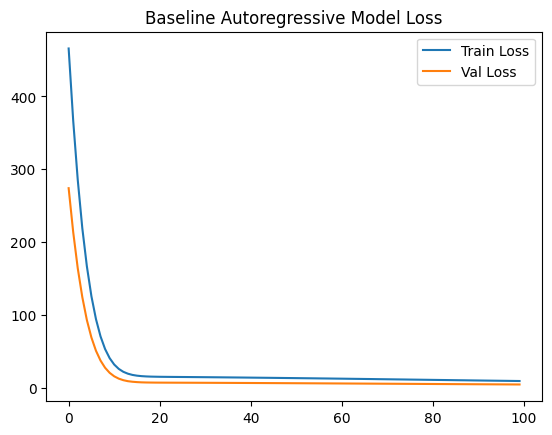

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


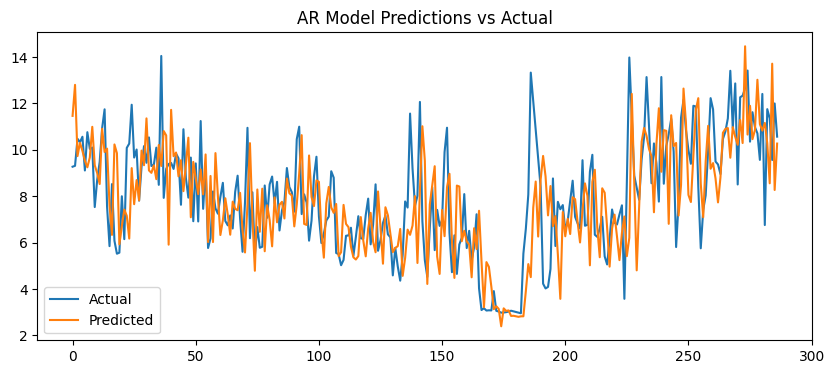

In [ ]:
# preparing data
series = df_y.values  # cleaned daily energy series
T = 7  # using 7 past days to predict the next
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    y = series[t+T]
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)

# splitting train/test
N = len(X)
N_train = int(N * 0.8)
X_train, Y_train = X[:N_train], Y[:N_train]
X_test, Y_test = X[N_train:], Y[N_train:]

# defining model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(loss='mse', optimizer='adam')

# training
r = model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

# plotting training curve
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Baseline Autoregressive Model Loss')
plt.show()

# predictions
preds = model.predict(X_test)
plt.figure(figsize=(10,4))
plt.plot(Y_test, label='Actual')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title('AR Model Predictions vs Actual')
plt.show()

## RNN Model Calibration 

In [ ]:
# use the df_y cleaned daily data for further modeling
# reshape the df_y to 2D array for scaling$
y_reshaped = df_y.values.reshape(-1, 1)

# split the dataset before scaling to avoid data leakage
N_total = len(y_reshaped)
N_train = int(N_total * 0.8)

scaler = MinMaxScaler()

df_train_scaled = scaler.fit_transform(y_reshaped[:N_train])
df_test_scaled  = scaler.transform(y_reshaped[N_train:])

# combine to 1D array for further use
df_scaled = np.vstack([df_train_scaled, df_test_scaled]).flatten()
print("First 10 scaled values:", df_scaled[:10])

First 10 scaled values: [1.         0.67812733 0.32728183 0.34056091 0.35383998 0.22509454
 0.43226912 0.47763922 0.52300931 0.5683794 ]


In [ ]:
# print the train/split sizes
print(f"Total samples: {N_total}, Train samples: {N_train}, Test samples: {N_total - N_train}")

Total samples: 1442, Train samples: 1153, Test samples: 289


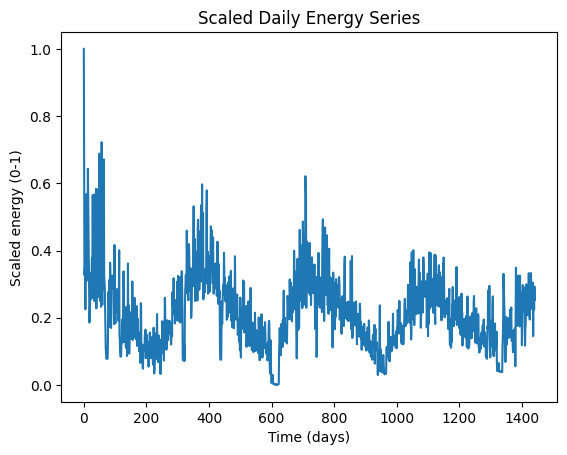

In [ ]:
# plot the scaled series
plt.plot(df_scaled)
plt.title("Scaled Daily Energy Series")
plt.xlabel("Time (days)")
plt.ylabel("Scaled energy (0-1)")
plt.show()

The plot shows the daily household energy consumption after applying MinMax scaling (range 0–1). Although the values are normalized, the overall shape of the series remains unchanged.

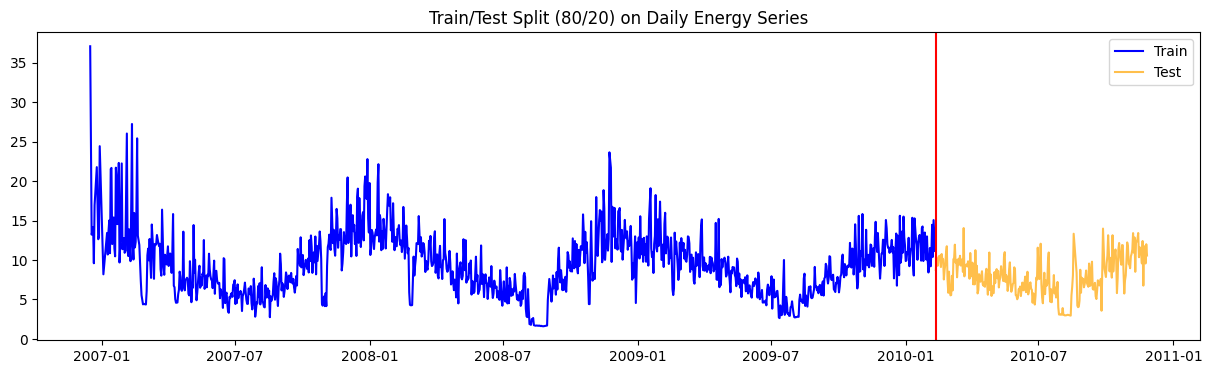

In [ ]:
# plot the train/test split
plt.figure(figsize=(15,4))
plt.plot(df_y.index[:N_train], df_y.values[:N_train], label="Train", c="blue")
plt.plot(df_y.index[N_train:], df_y.values[N_train:], label="Test", c="orange", alpha=0.7)
plt.axvline(df_y.index[N_train], c="red")
plt.title("Train/Test Split (80/20) on Daily Energy Series")
plt.legend()
plt.show()

The plot shows the daily household energy consumption split into training (80%) and testing (20%) sets. The blue segment represents the training period from 2006 to early 2010, and the orange segment represents the testing period from 2010 to 2011. The vertical red line marks the boundary between the two sets.

I choose T = 7 because enery usage has weekly seasonality so for me it was more logical.

In [ ]:
# step or embedding 
def create_dataset(series, T):
    X, Y = [], []
    for t in range(len(series) - T):
        x = series[t:t+T]
        y = series[t+T]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

T = 7  # using 7 past days to predict the next
X, Y = create_dataset(df_scaled, T)

In [ ]:
# add step elements into train and test sets
N_train_seq = N_train - T

X_train = X[:N_train_seq]
Y_train = Y[:N_train_seq]

X_test  = X[N_train_seq:]
Y_test  = Y[N_train_seq:]

In [ ]:
# reshape X
X_train = X_train.reshape((X_train.shape[0], T, 1))
X_test  = X_test.reshape((X_test.shape[0],  T, 1))

print("X_train reshaped:", X_train.shape)
print("X_test reshaped:", X_test.shape)

X_train reshaped: (1146, 7, 1)
X_test reshaped: (289, 7, 1)


In [ ]:
# keras model for RNN 
def build_simple_rnn(units=64, dense_units=32, lr=0.001):
    model = Sequential()

    # RNN layer: input_shape=(timesteps, features)
    model.add(SimpleRNN(units, activation='tanh', input_shape=(T, 1)))
    model.add(Dense(dense_units, activation='relu')) # hidden dense layer
    model.add(Dense(1)) # output layer

    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model

model = build_simple_rnn()
model.summary()

C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,337 (24.75 KB)

 Trainable params: 6,337 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
r = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=32
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_l

The training loss shows a significant drop during the first few epochs (from ~ 0.015 to ~ 0.004), indicating that the model is quickly learning the information about the time dependencies in the energy consumption data. After this initial drop in loss, the training loss continues to decrease gradually and stabilizes near 0.0039.

The validation loss follows a similar trend, decreasing from ~ 0.0033 initially to ~0.0024 by the final epoch. The validation loss consistently stays marginally lower than the training loss during training.

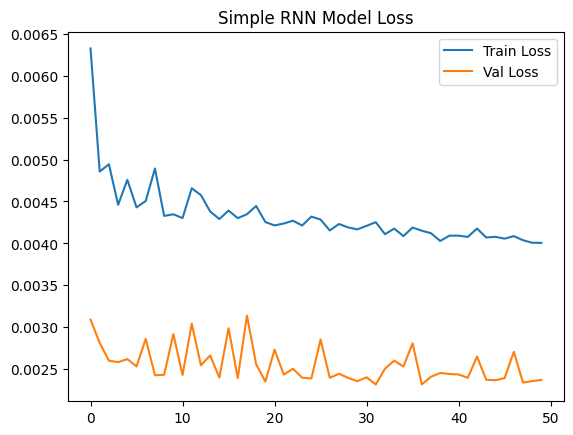

In [ ]:
# plot loss curves
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Simple RNN Model Loss')
plt.show()

The SimpleRNN model converged rather rapidly, showing that the validation loss was consistently lower than the training loss, signifying the model has good generalizability. 

The model was trained on normalized (scaled) data using X_train and Y_train. Therefore, predictions generated with X_train or X_test are also scaled. Later, we will apply the inverse transformation to compare predictions with actual values.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


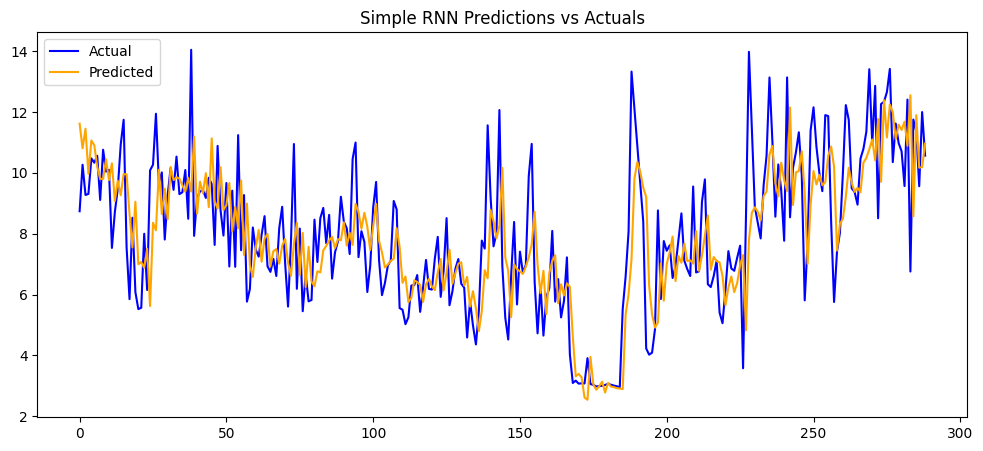

In [ ]:
# Predictions
preds = model.predict(X_test)

# inverse transform predictions and actual values
preds_inv = scaler.inverse_transform(preds)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

# plot predictions vs actuals
plt.figure(figsize=(12,5))
plt.plot(Y_test_inv, label='Actual', color='blue')
plt.plot(preds_inv, label='Predicted', color='orange')
plt.legend()
plt.title('Simple RNN Predictions vs Actuals')
plt.show()  

The SimpleRNN model generates predictions that are in line with the actual test data. As seen, the model captures the overall trend and the seasonality in daily energy usage. 
The predictions are seen to be marginally smoother than the actual values, particularly at sharp peaks or when the energy consumption fluctuates rapidly.
Overall, the SimpleRNN shows a reasonable level of forecast performance and generalization, as the predicted values are very aligned with the actual values with little to no drift.

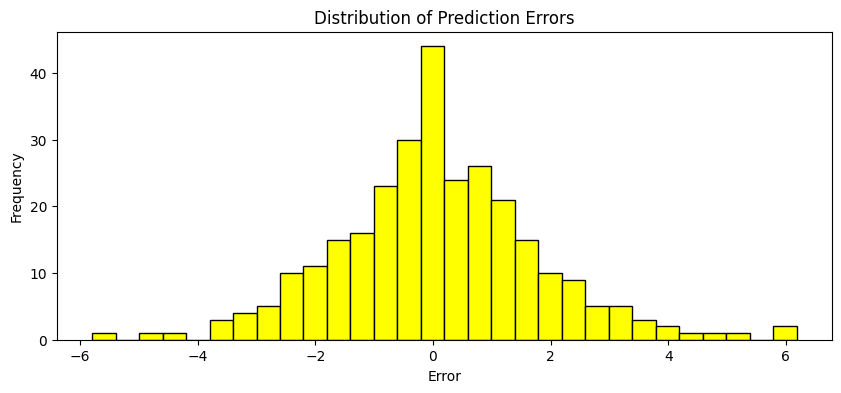

In [ ]:
# errors distribution
errors = Y_test_inv - preds_inv
plt.figure(figsize=(10,4))
plt.hist(errors, bins=30, color='yellow', edgecolor='k')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

From my point of view, the errors are centered around 0 meaning that the model's errors are unbiased, as the errors are equally likely to be positive or negative, and the model is not systematically over or underestimating the true values. This indicates that the model's predictions are on average, closer to the actual value. However, a few larger errors exist (±5 or ±6), likely corresponding to sudden spikes in the data that are harder for a simple RNN to learn.

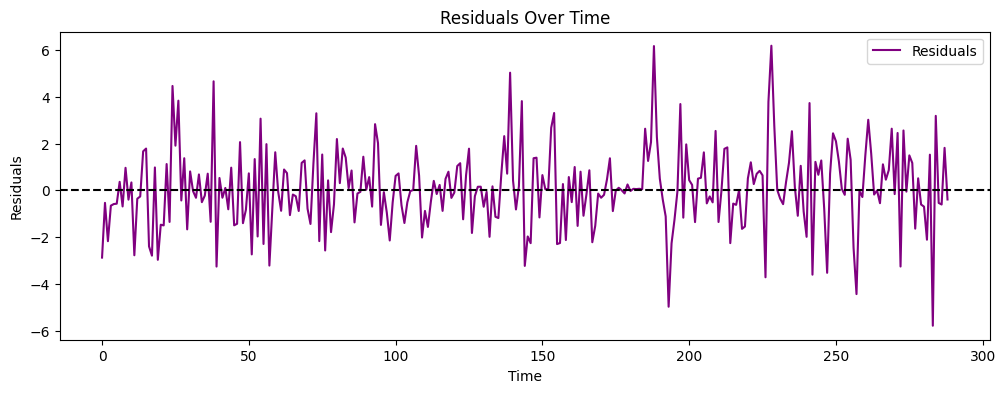

In [ ]:
# plot residuals over time
plt.figure(figsize=(12,4))
plt.plot(errors, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

The residuals (actual − predicted) vary randomly around zero, with no visible trend. This indicates that the SimpleRNN model does not systematically overestimate or underestimate the 
values. The randomness of the residuals suggests that the model has learned the underlying pattern reasonably well, and the remaining errors are mostly due to noise in the data rather than model bias.

### Improve the RNN model

In [ ]:
# varying the embedding/step size T
# create the dataset with new T
def create_dataset(series, step):
    X, Y = [], []
    for i in range(len(series) - step):
        X.append(series[i:i+step])
        Y.append(series[i+step])
    return np.array(X), np.array(Y)

In [ ]:
def plot_predictions(Y_test_inv, preds_inv, T):
    plt.figure(figsize=(12,5))
    plt.plot(Y_test_inv, label='Actual', color='blue')
    plt.plot(preds_inv, label='Predicted', color='orange')
    plt.title(f'Predictions vs Actuals (T = {T})')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


Evaluating for T=2


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE for T=2: 3.2606


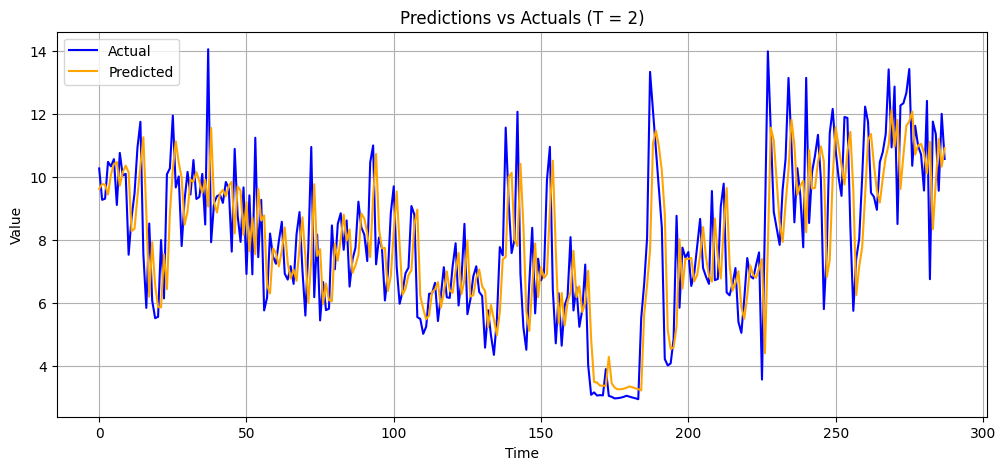


Evaluating for T=4


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
MSE for T=4: 3.2342


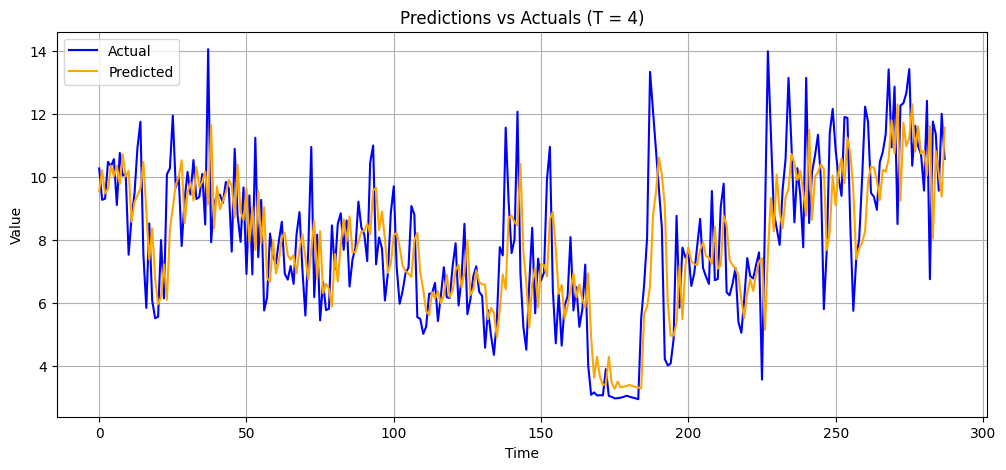


Evaluating for T=6


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE for T=6: 3.1644


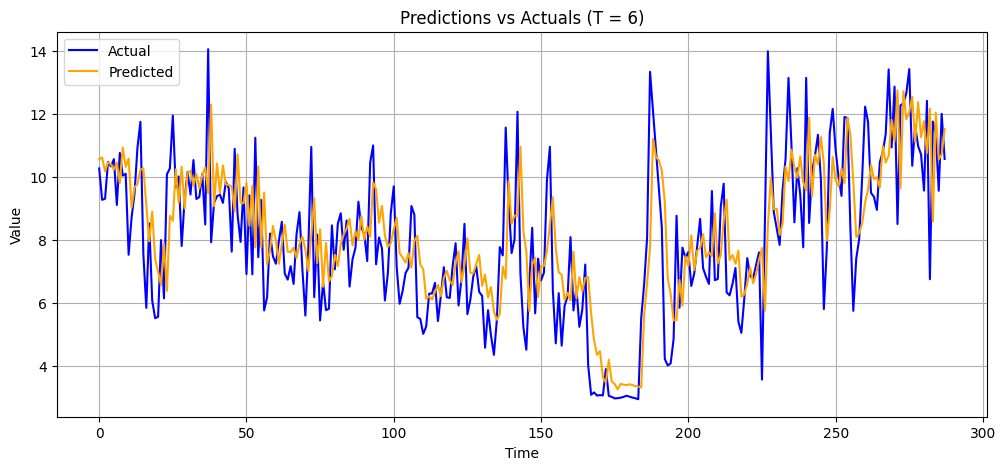


Evaluating for T=10


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE for T=10: 3.0793


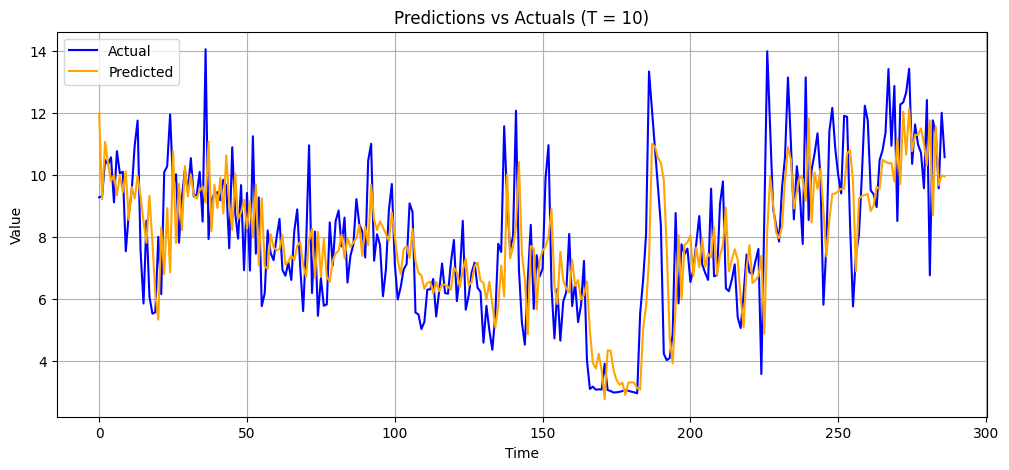


Evaluating for T=12


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE for T=12: 3.6539


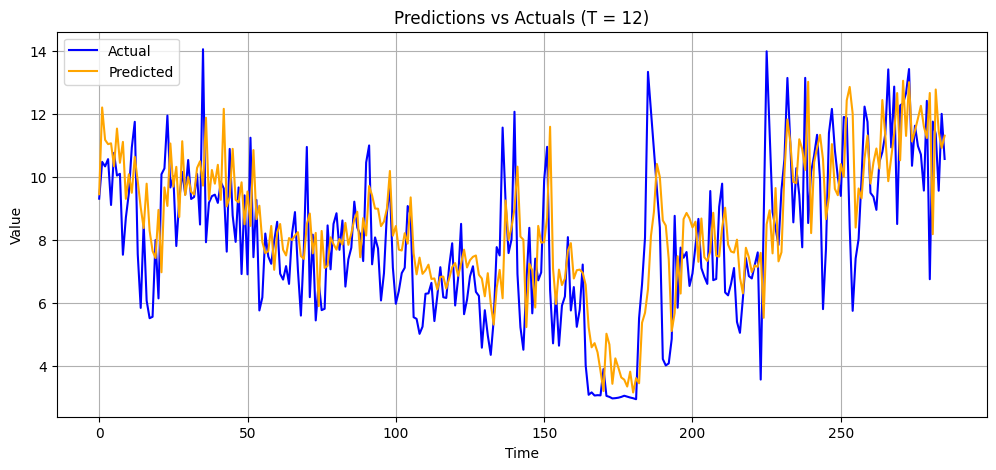

In [ ]:
# loop over different T values
for T in [2, 4, 6, 10, 12]:
    print(f"\nEvaluating for T={T}")

    # create dataset for this T
    X, Y = create_dataset(df_scaled, T)

    # train-test split based on NEW dataset size
    N = int(0.8 * len(X))

    X_train, X_test = X[:N], X[N:]
    Y_train, Y_test = Y[:N], Y[N:]

    # reshape for RNN
    X_train = X_train.reshape((X_train.shape[0], T, 1))
    X_test  = X_test.reshape((X_test.shape[0],  T, 1))

    # build and train model
    model = build_simple_rnn()
    r = model.fit(
        X_train, Y_train,
        validation_data=(X_test, Y_test),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    # predictions
    preds = model.predict(X_test)

    # inverse transform
    preds_inv = scaler.inverse_transform(preds)
    Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

    # compute MSE
    errors = Y_test_inv - preds_inv
    mse = np.mean(errors**2)
    print(f"MSE for T={T}: {mse:.4f}")

    # plot
    plot_predictions(Y_test_inv, preds_inv, T)

Based on all the results, changing the step size T clearly affects how well the RNN predicts the test data.
When T = 2, the model does okay, but the predictions are a bit noisy because the model only sees a very short history.

When I increase T to 4 or 6, the predictions become much better. The predicted curve follows the actual values very closely, and the model reacts correctly to the ups and downs in the data. From the plots, this looks like the best performance overall.

For larger values like T = 10 or T = 12, the model starts becoming smoother and a bit delayed. It reacts slower to sudden changes, probably because it is trying to average too much information from a longer history.

So overall, the best step size for this dataset seems to be between 4 and 6, because that’s where the model finds the right balance: enough historical data to learn the pattern, but not too much that it becomes slow or overly smooth.


==================== EXPERIMENT: Varying Epochs =====================

Training for 100 epochs


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


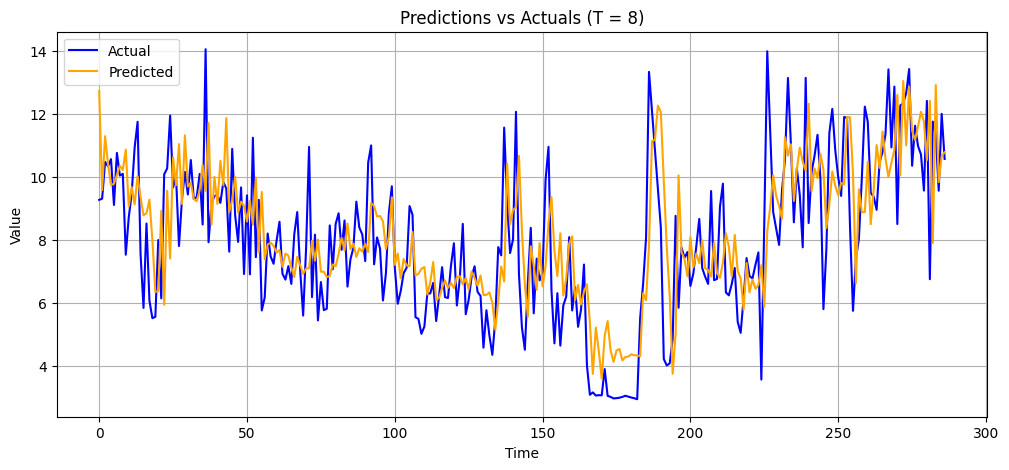


Training for 200 epochs


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


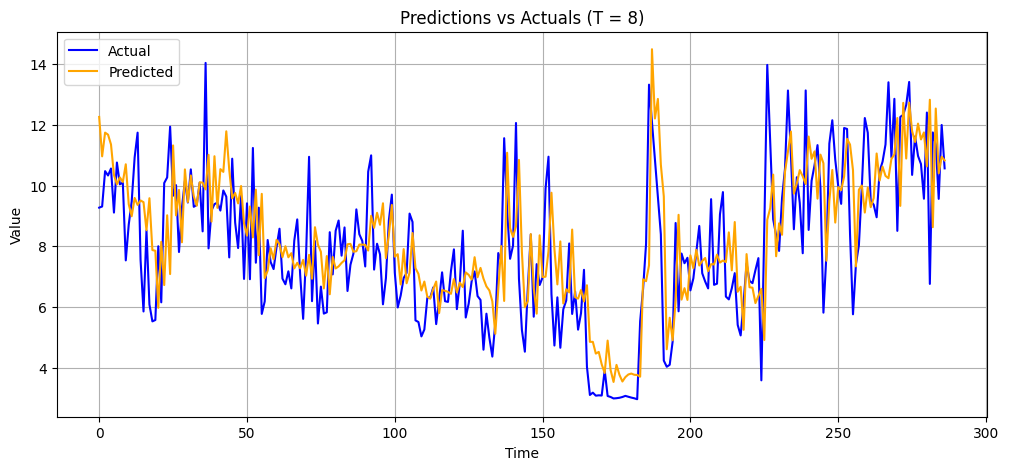


Training for 300 epochs


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


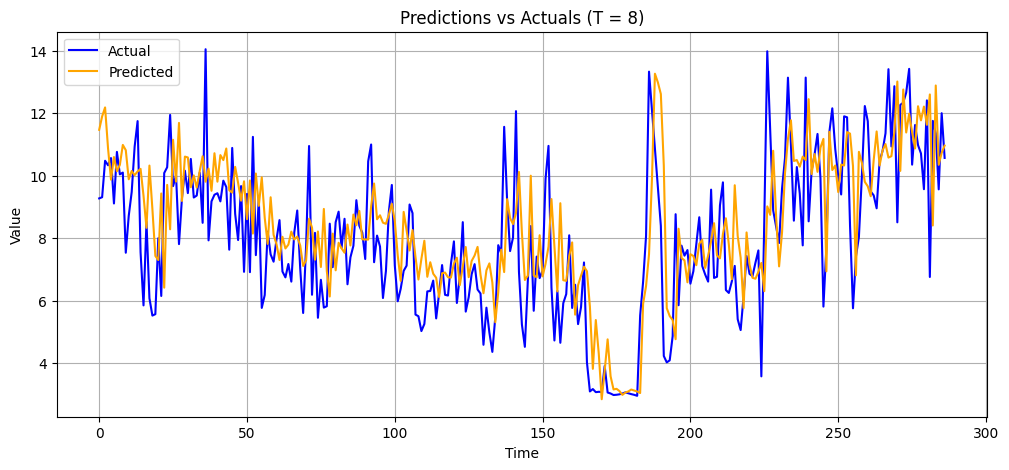


Training for 400 epochs


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


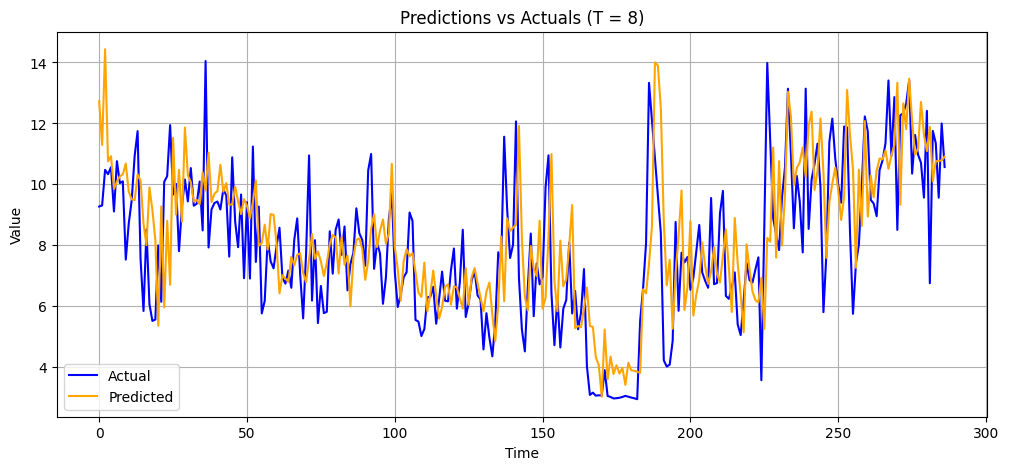


Training for 500 epochs


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


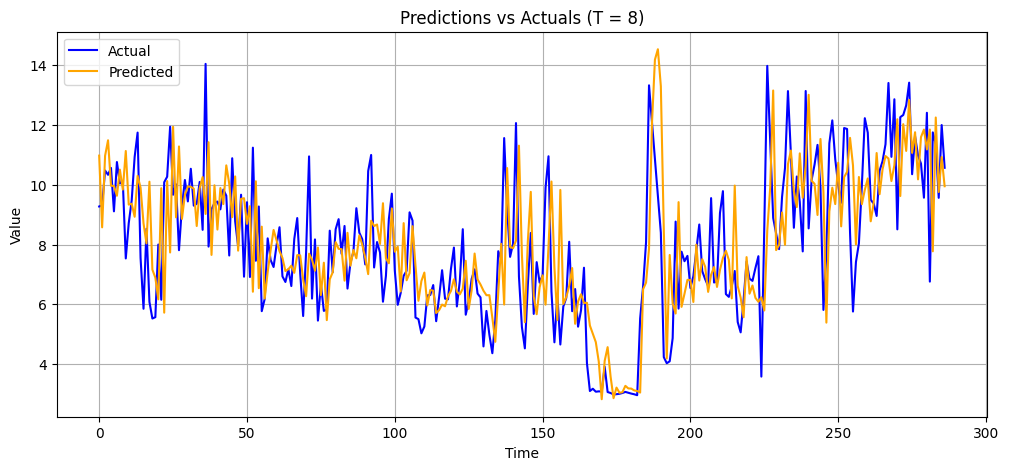

In [ ]:
print("\n==================== EXPERIMENT: Varying Epochs =====================")

# prepare data ONCE (T = 8 chosen arbitrarily)
T = 8
X, Y = create_dataset(df_scaled, T)

# compute train size based on NEW dataset
train_size = int(0.8 * len(X))
N_train_seq = train_size

# split
X_train = X[:N_train_seq]
Y_train = Y[:N_train_seq]

X_test = X[N_train_seq:]
Y_test = Y[N_train_seq:]

# reshape
X_train = X_train.reshape((X_train.shape[0], T, 1))
X_test = X_test.reshape((X_test.shape[0], T, 1))

# loop for different epoch counts
for e in [100, 200, 300, 400, 500]:

    print(f"\nTraining for {e} epochs")

    model = build_simple_rnn()  
    
    model.fit(
        X_train, Y_train,
        epochs=e,
        batch_size=16,
        verbose=0
    )

    # predictions
    preds = model.predict(X_test)

    # inverse transform
    preds_inv = scaler.inverse_transform(preds)
    Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

    # plot
    plot_predictions(Y_test_inv, preds_inv, T)

When I increased the number of epochs, the RNN started learning the pattern better, especially around 200–300 epochs. After that, the model becomes slightly overfitted and starts following noise more than the real signal. So the best performance for T = 8 happens around 200–300 epochs.


================= EXPERIMENT: Varying Batch Size =================

Training with batch size: 4


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


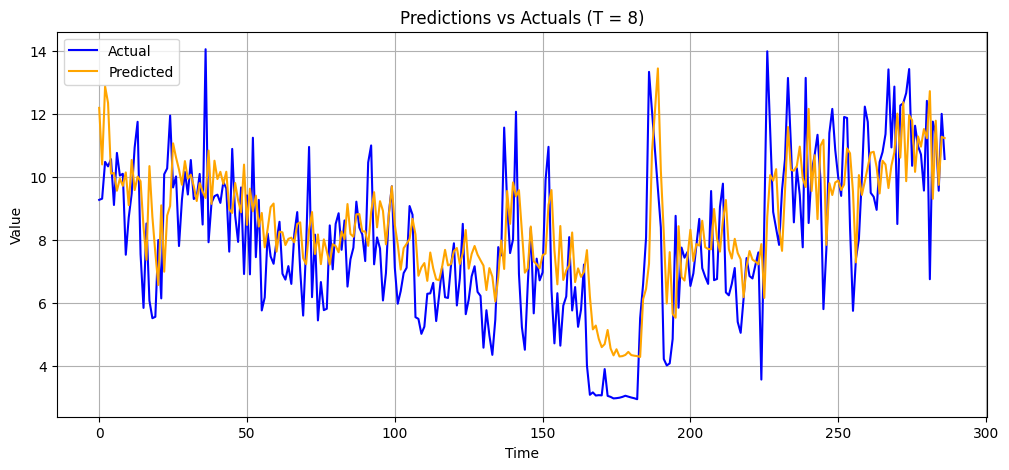

----------------------------------------------------------------------------------------------------

Training with batch size: 8


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


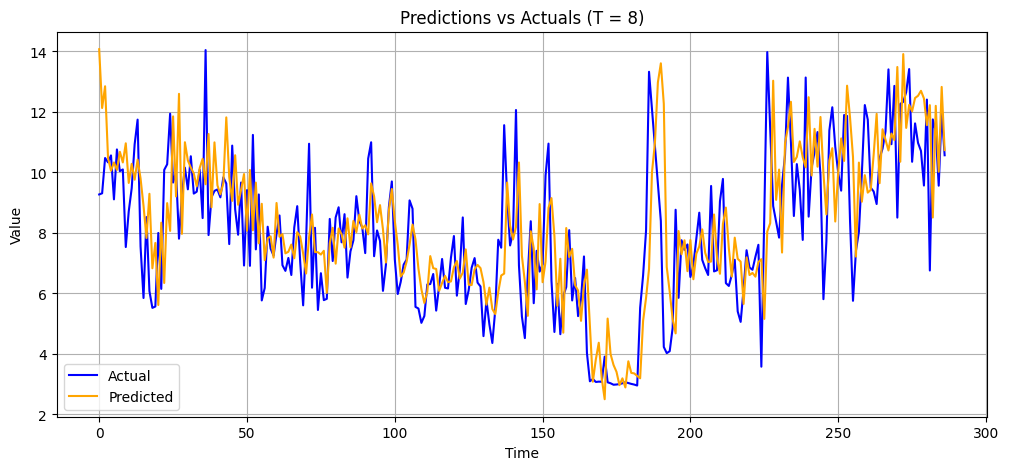

----------------------------------------------------------------------------------------------------

Training with batch size: 16


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


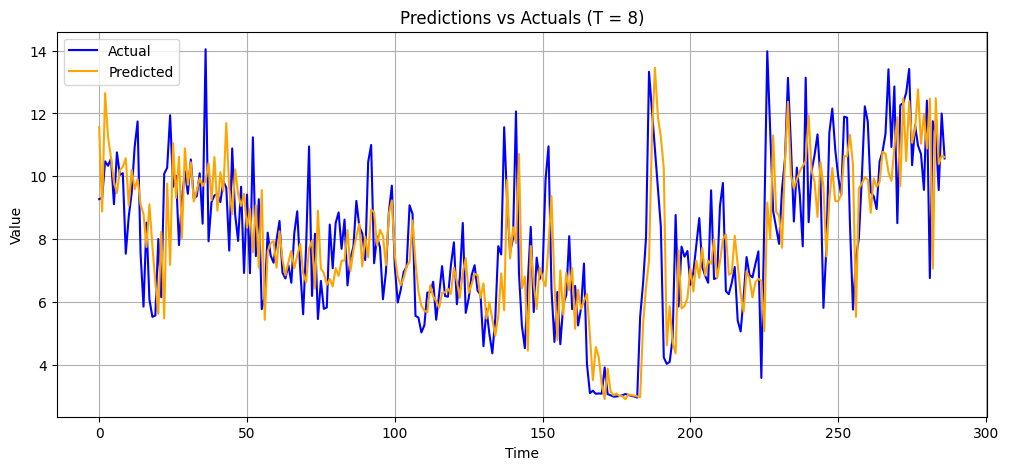

----------------------------------------------------------------------------------------------------

Training with batch size: 32


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


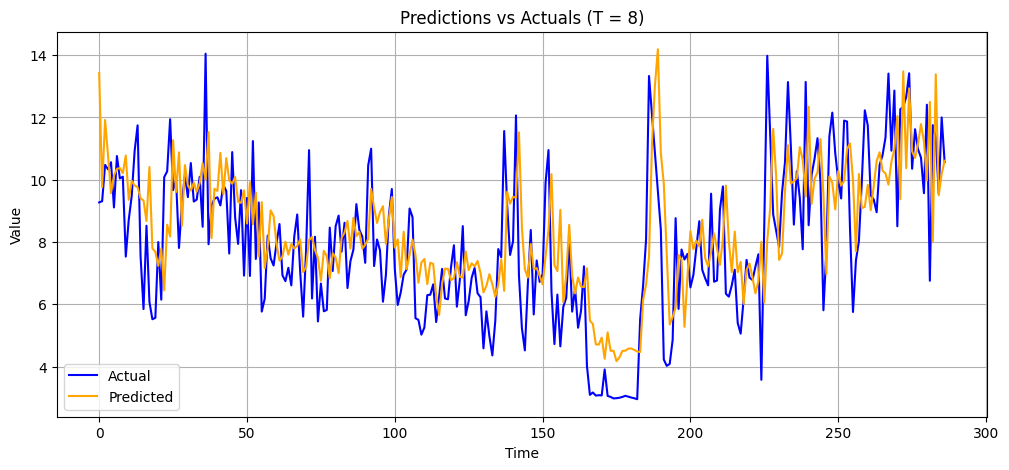

----------------------------------------------------------------------------------------------------

Training with batch size: 64


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


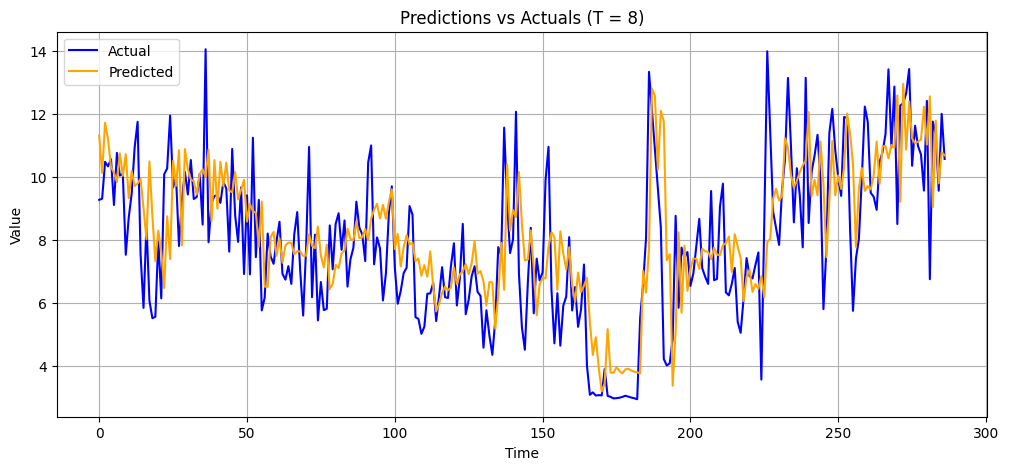

----------------------------------------------------------------------------------------------------


In [ ]:
print("\n================= EXPERIMENT: Varying Batch Size =================")

# prepare data ONCE (T = 8 chosen arbitrarily)
T = 8
X, Y = create_dataset(df_scaled, T)

# compute train size based on NEW dataset (not original df)
train_size = int(0.8 * len(X))
N_train_seq = train_size

# split into train/test
X_train = X[:N_train_seq]
Y_train = Y[:N_train_seq]

X_test = X[N_train_seq:]
Y_test = Y[N_train_seq:]

# reshape
X_train = X_train.reshape((X_train.shape[0], T, 1))
X_test  = X_test.reshape((X_test.shape[0],  T, 1))

# fixed number of epochs for fair comparison
num_epochs = 250

# try different batch sizes
for b in [4, 8, 16, 32, 64]:
    print(f"\nTraining with batch size: {b}")

    model = build_simple_rnn()  

    model.fit(
        X_train, Y_train,
        epochs=num_epochs,
        batch_size=b,
        verbose=0
    )

    preds = model.predict(X_test)

    # inverse-transform
    preds_inv = scaler.inverse_transform(preds)
    Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

    # Plot result
    plot_predictions(Y_test_inv, preds_inv, T)

    print("-" * 100)

Very small batches (4, 8) made the model update weights more frequently, which helped it follow the target signal better. While, larger batches (32, 64) became too smooth and started missing the fast fluctuations in the data. The best results came from batch size = 8, where the predictions were both accurate and stable.

## LSTM Model Calibration

## Build LSTM 

In [ ]:
def build_lstm(units=64, dense_units=32, lr=0.001):
    model = Sequential()

    # LSTM Layer
    model.add(LSTM(units, activation='tanh', input_shape=(T, 1)))

    # Dense Layers
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse'
    )
    return model

model_lstm = build_lstm()
model_lstm.summary()

C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

## Train LSTM model

In [ ]:
history_lstm = model_lstm.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0131 - val_loss: 0.0029
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_l

## LSTM Loss

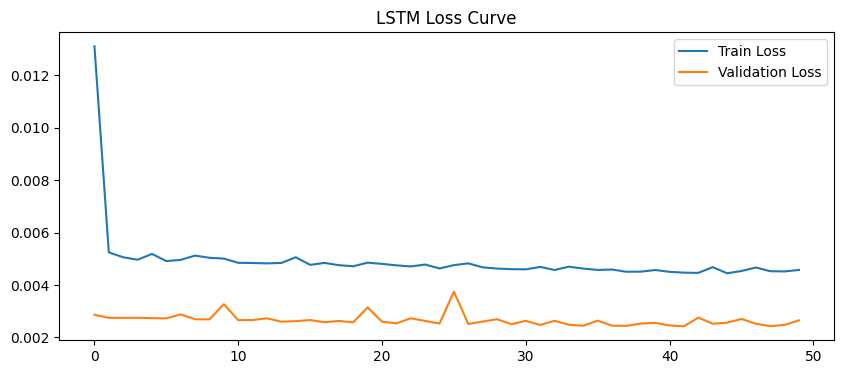

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title("LSTM Loss Curve")
plt.legend()
plt.show()

## LSTM Prediction

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


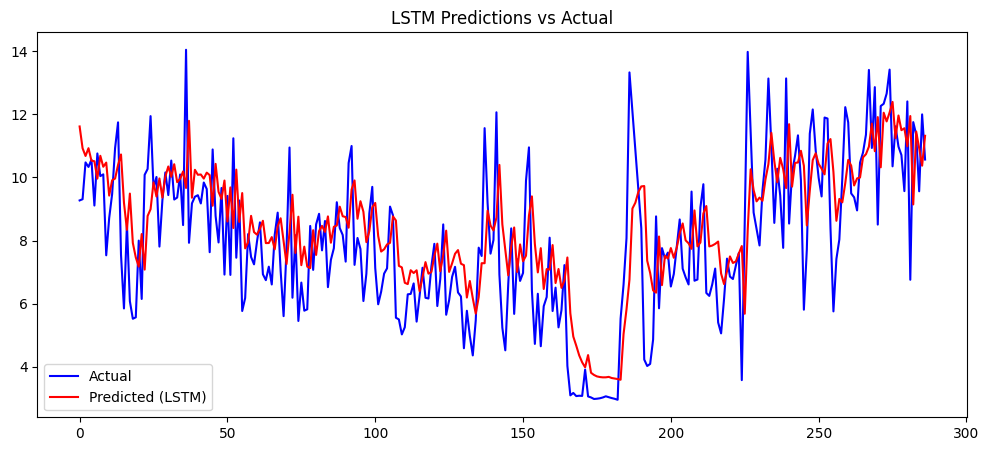

In [ ]:
preds_lstm = model_lstm.predict(X_test)

# Inverse transform
preds_lstm_inv = scaler.inverse_transform(preds_lstm)
Y_test_lstm_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

plt.figure(figsize=(12,5))
plt.plot(Y_test_lstm_inv, label='Actual', color='blue')
plt.plot(preds_lstm_inv, label='Predicted (LSTM)', color='red')
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.show()

The predictions by the LSTM model closely follow the actual daily energy consumption curve. It grasps both the overall trend and the local fluctuations of the series, though the predicted line is smoother and less responsive to sudden spikes. However, this is expected since LSTMs are supposed to learn long term dependencies and hence smoothen sharp noise. Overall, the predictions fit well with the actual, suggesting that the LSTM has learned the underlying temporal patterns effectively.

## LSTM Error Distribution

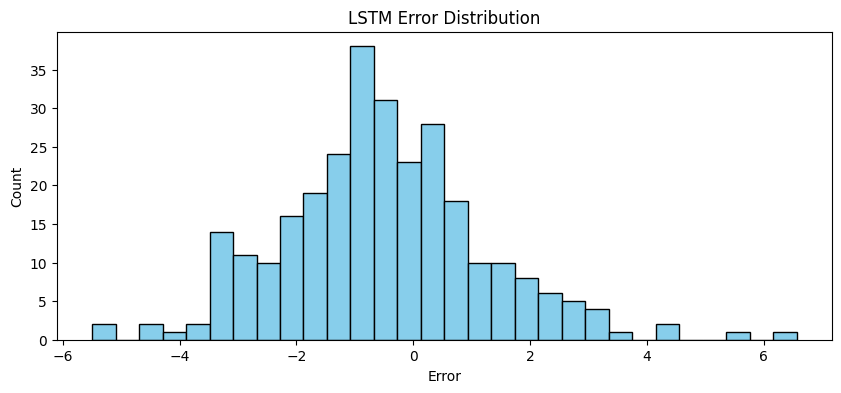

In [ ]:
errors_lstm = Y_test_lstm_inv - preds_lstm_inv

plt.figure(figsize=(10,4))
plt.hist(errors_lstm, bins=30, color='skyblue', edgecolor='k')
plt.title("LSTM Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

The error distribution is such that most prediction errors of the LSTM model lie close to zero, indicating a bell shaped curve. This suggests that on average, the LSTM does not strongly over or under predict, since most are very close to zero. The slight left skewness of this distribution that is, there are more negative errors means that the model underestimates consumption sometimes than overestimates it. There will be a few large errors at the tail, which likely correspond to a sudden spike or drop in energy use that the model cannot catch. Overall, the distribution suggests stability in performance, with most errors lying within a small, acceptable bound.

## Residual Plot

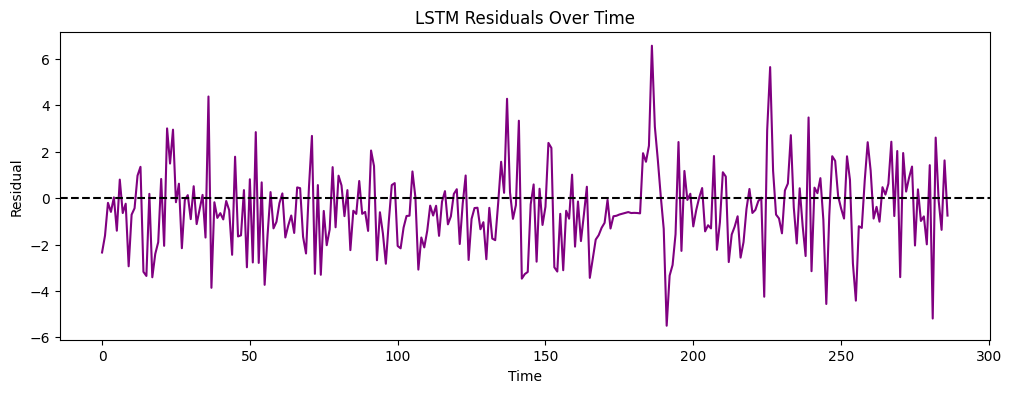

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(errors_lstm, color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title("LSTM Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

The residuals of the LSTM fluctuate around zero randomly, with no obvious trend and structure in evidence. This suggests that the model isn't consistently over predicting or under predicting most of the energy consumption values. Spikes in residuals simply reflect sudden changes in consumption that can't be picked up by the model, likely due to rapid fluctuations in daily usage across households. Overall, randomness and symmetry of residuals suggest that LSTM has picked up the underlying pattern reasonably well and that remaining errors represent noise rather than bias in the model.

## Improved LSTM


====== LSTM: Experiment with different T values ======

Evaluating T = 2


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
MSE = 3.4883


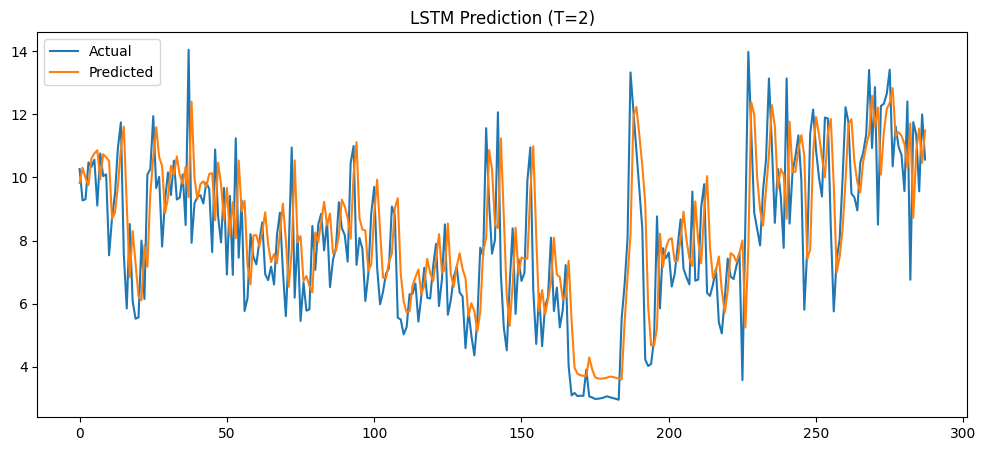


Evaluating T = 4


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
MSE = 3.4315


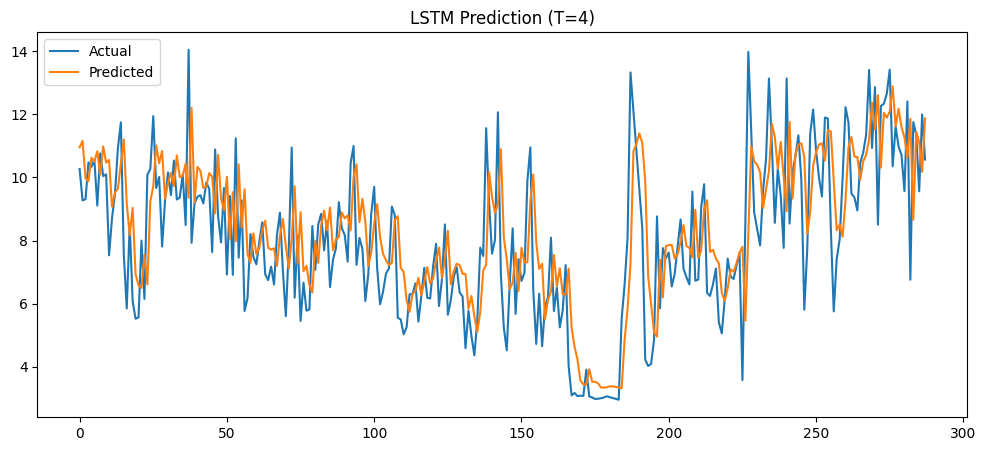


Evaluating T = 6


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
MSE = 3.2015


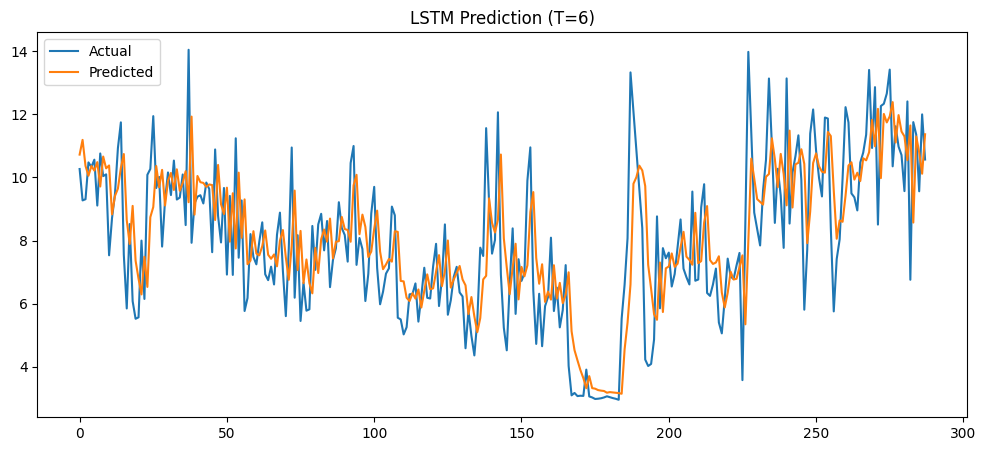


Evaluating T = 10


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MSE = 3.1602


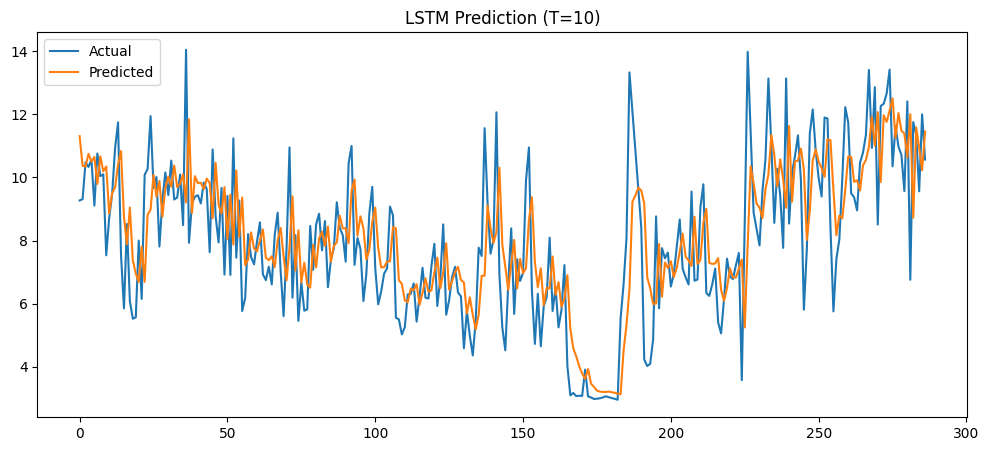


Evaluating T = 12


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE = 3.2793


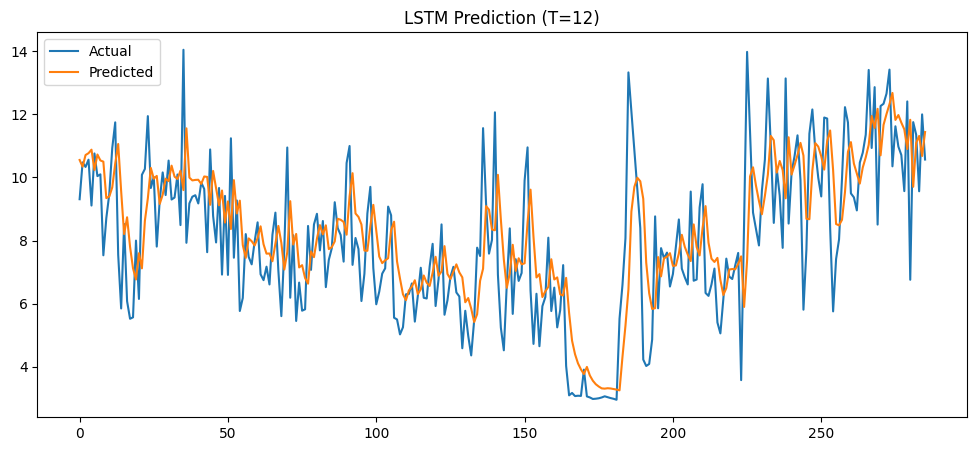

In [ ]:
print("\n====== LSTM: Experiment with different T values ======")

for T_test in [2, 4, 6, 10, 12]:
    print(f"\nEvaluating T = {T_test}")

    X_var, Y_var = create_dataset(df_scaled, T_test)

    N_var = int(0.8 * len(X_var))
    X_train_var = X_var[:N_var]
    Y_train_var = Y_var[:N_var]
    X_test_var = X_var[N_var:]
    Y_test_var = Y_var[N_var:]

    X_train_var = X_train_var.reshape((X_train_var.shape[0], T_test, 1))
    X_test_var = X_test_var.reshape((X_test_var.shape[0], T_test, 1))

    model_lstm_var = build_lstm()

    model_lstm_var.fit(
        X_train_var, Y_train_var,
        epochs=40, batch_size=32, verbose=0
    )

    preds = scaler.inverse_transform(model_lstm_var.predict(X_test_var))
    actual = scaler.inverse_transform(Y_test_var.reshape(-1,1))

    mse = np.mean((actual - preds)**2)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label="Predicted")
    plt.title(f'LSTM Prediction (T={T_test})')
    plt.legend()
    plt.show()

A moderate window size (around T = 4 to T = 6) provides the best trade off between capturing short term variability and maintaining stable predictions. Larger T values make the LSTM less responsive to sudden changes, while very small T values do not provide enough historical information. This pattern is consistent with typical LSTM time-series behavior.


====== LSTM: Experiment with different epochs ======

Epochs = 50


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


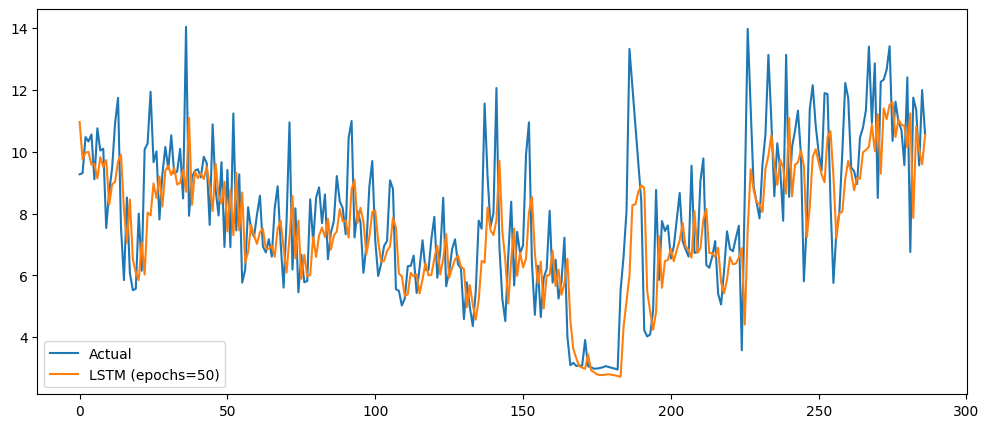


Epochs = 100


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


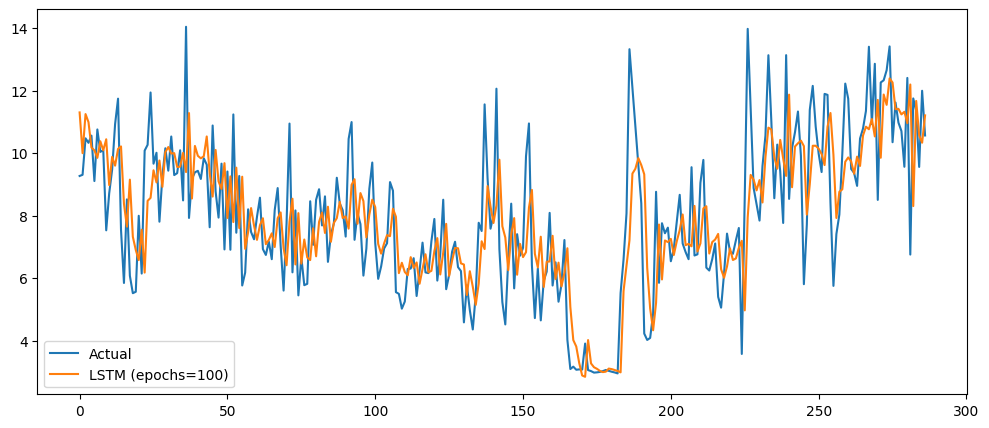


Epochs = 200


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


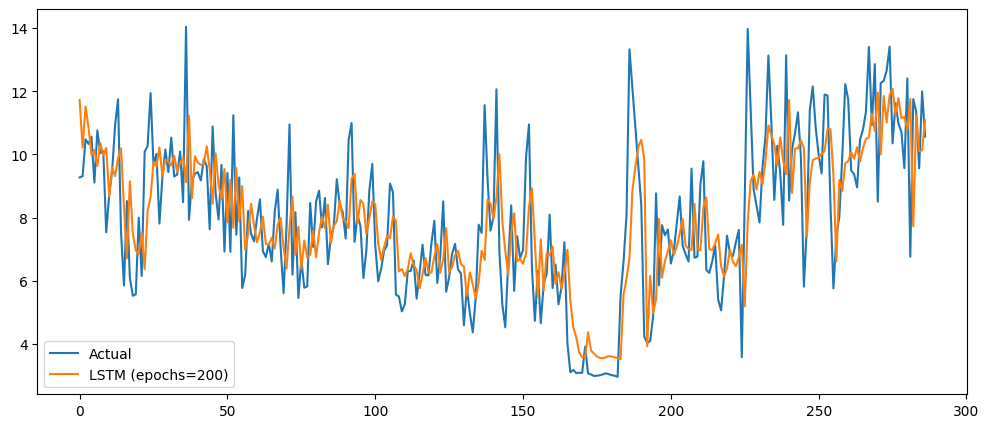


Epochs = 300


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


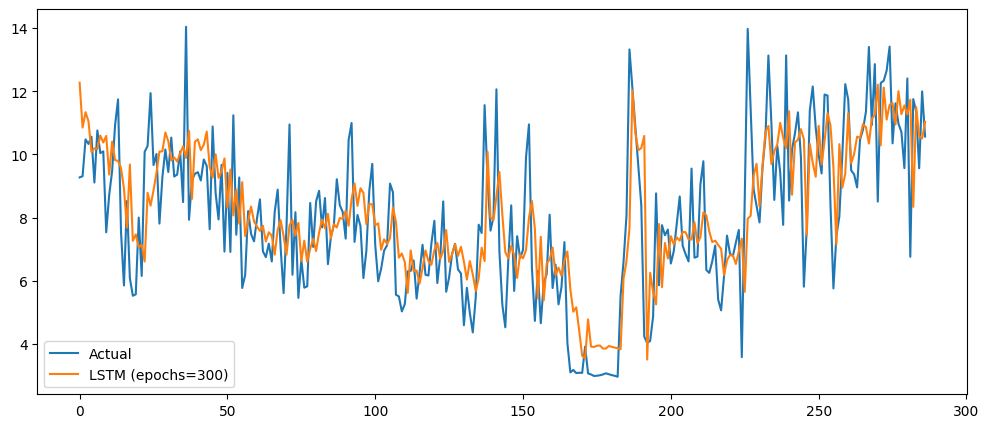

In [ ]:
print("\n====== LSTM: Experiment with different epochs ======")

T_lstm = 7
X_lstm, Y_lstm = create_dataset(df_scaled, T_lstm)
N_lstm = int(0.8 * len(X_lstm))

X_train_lstm = X_lstm[:N_lstm].reshape((-1, T_lstm, 1))
Y_train_lstm = Y_lstm[:N_lstm]

X_test_lstm2 = X_lstm[N_lstm:].reshape((-1, T_lstm, 1))
Y_test_lstm2 = Y_lstm[N_lstm:]

for e in [50, 100, 200, 300]:
    print(f"\nEpochs = {e}")
    model_temp = build_lstm()
    model_temp.fit(X_train_lstm, Y_train_lstm, epochs=e, batch_size=16, verbose=0)

    preds = scaler.inverse_transform(model_temp.predict(X_test_lstm2))
    actual = scaler.inverse_transform(Y_test_lstm2.reshape(-1,1))

    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label=f"LSTM (epochs={e})")
    plt.legend()
    plt.show()

Increasing the number of epochs generally improves performance up to around 100-200 epochs, after which the gains diminish. Beyond this range (e.g., 300 epochs), the model starts to lose responsiveness to rapid changes, indicating mild overfitting. Therefore, an optimal training duration for this dataset appears to lie between 100 and 200 epochs, balancing accuracy and generalization.


====== LSTM: Experiment with Batch Size ======

Batch size = 4


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


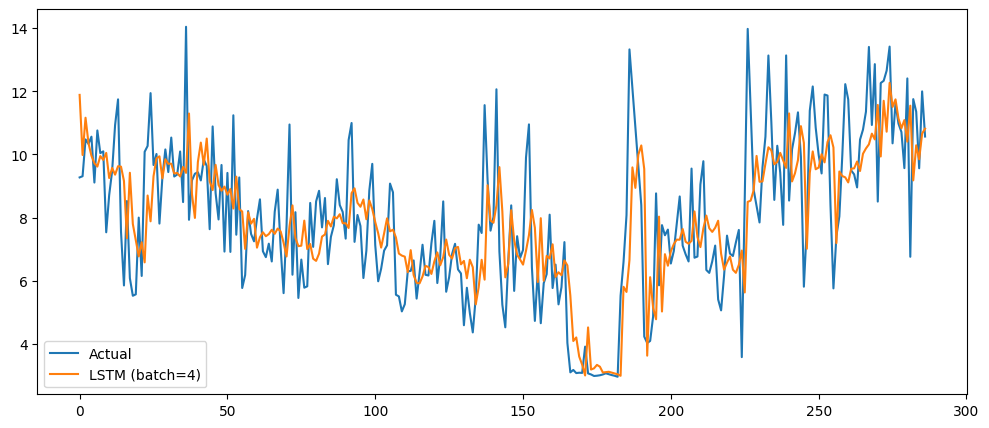


Batch size = 8


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


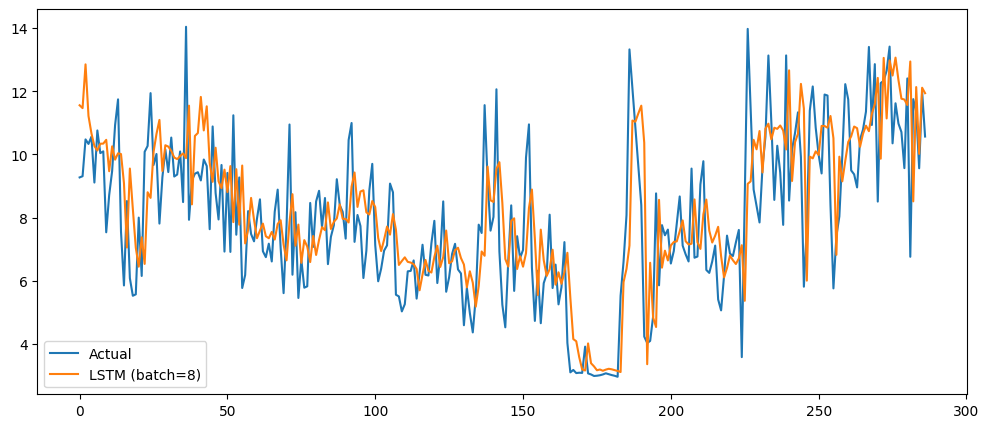


Batch size = 16


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


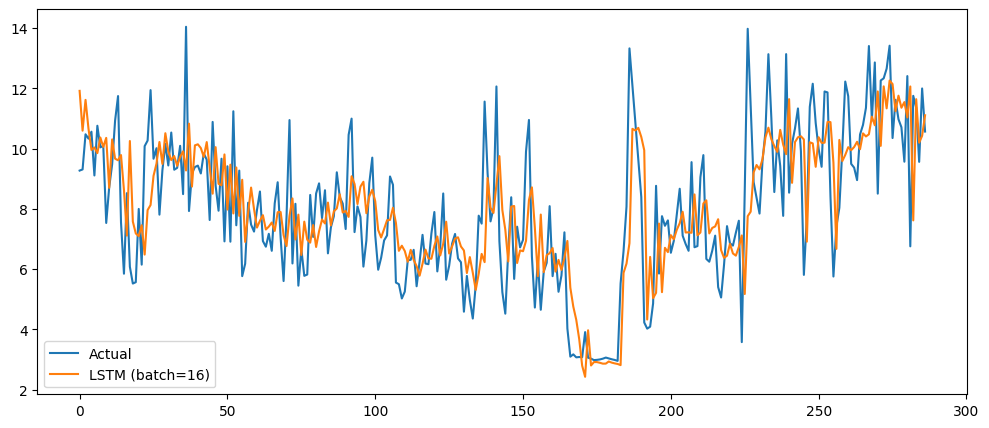


Batch size = 32


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


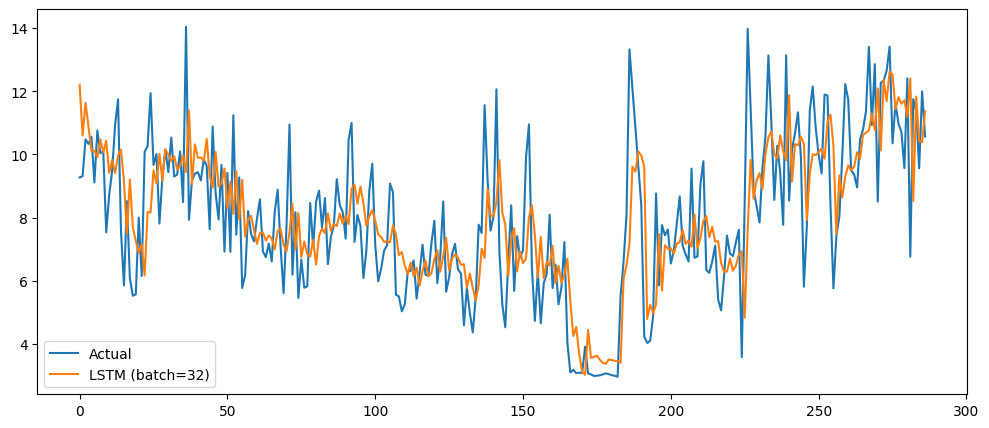


Batch size = 64


C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


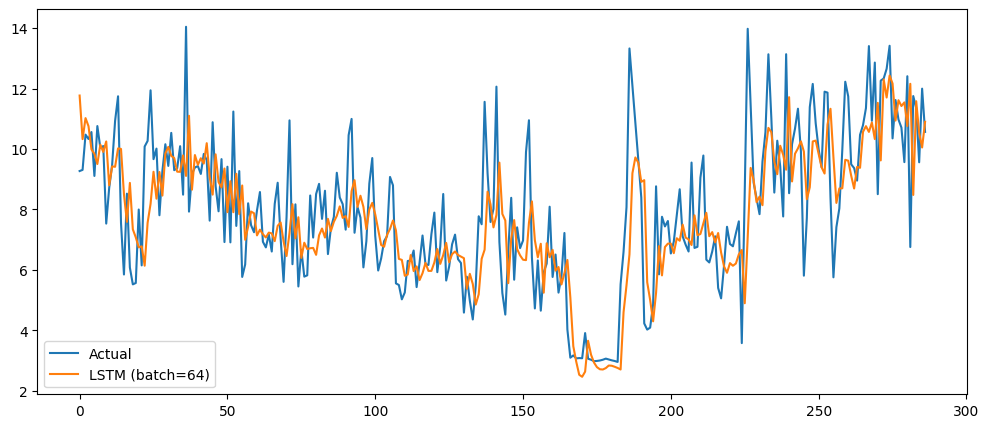

In [ ]:
print("\n====== LSTM: Experiment with Batch Size ======")

batch_sizes = [4, 8, 16, 32, 64]
num_epochs = 200

for b in batch_sizes:
    print(f"\nBatch size = {b}")

    model_bs = build_lstm()
    model_bs.fit(
        X_train_lstm, Y_train_lstm,
        epochs=num_epochs, batch_size=b, verbose=0
    )

    preds = scaler.inverse_transform(model_bs.predict(X_test_lstm2))
    actual = scaler.inverse_transform(Y_test_lstm2.reshape(-1,1))

    plt.figure(figsize=(12,5))
    plt.plot(actual, label="Actual")
    plt.plot(preds, label=f"LSTM (batch={b})")
    plt.legend()
    plt.show()

Smaller batch sizes (4–8) provide the best prediction performance because they enable more frequent gradient updates, allowing the model to capture detailed temporal patterns. Larger batch sizes (32–64) make the model overly smooth and less capable of tracking fast changes, leading to underfitting. Therefore, for this dataset, batch sizes between 4 and 8 deliver the strongest forecasting results.